In [121]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats
from autograd import grad

In [160]:
def build_loss(X, T):
        
    #mean-center data
    X = X - np.mean(X, axis=0)
    
    #Compute N-by-N cross-covariance matrices for all 0<=delta_t<=2*T-1
    N = X.shape[1]
    cross_cov_mats = np.zeros((2*T, N, N))
    for delta_t in range(2*T):
        cross_cov = np.dot(X[delta_t:].T, X[:len(X)-delta_t])/(len(X) - delta_t - 1)
        cross_cov_mats[delta_t] = cross_cov
        
    #Compute 2*T*N-by-2*T*N cross-covariance matrix
    C_2T = np.zeros((2*T*N, 2*T*N))
    for delta_t in range(2*T):
        #upper diagonal
        C_2T[:2*T*N-delta_t*N, delta_t*N:] += np.kron(np.eye(2*T - delta_t), cross_cov_mats[delta_t])
        
        #upper diag = lower diag if delta_t == 0
        if delta_t == 0:
            continue
        
        #lower-diagonal
        C_2T[delta_t*N:, :2*T*N-delta_t*N] += np.kron(np.eye(2*T - delta_t), cross_cov_mats[delta_t])
        
    #Get T*N-by-T*N cross-covariance matrix
    C_T = C_2T[:T*N, :T*N]
        
    #Define loss functon
    def loss(v):

        v_column = np.reshape(v, (len(v), 1))
        v_norm = v_column / np.sqrt(np.sum(v_column**2))

        V_T = np.kron(np.eye(T), v_norm)
        V_2T = np.kron(np.eye(2*T), v_norm)
        
        autocov_T = np.dot(V_T.T, np.dot(C_T, V_T))
        autocov_2T = np.dot(V_2T.T, np.dot(C_2T, V_2T))

        sgn_T, logdet_T = np.linalg.slogdet(autocov_T)
        sgn_2T, logdet_2T = np.linalg.slogdet(autocov_2T)

        PI = 2*logdet_T - logdet_2T
        return -PI #Loss function (low negative PI = high PI)
    
    return loss

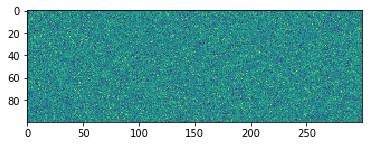

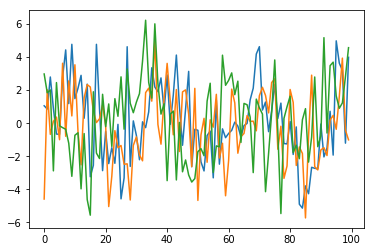

In [213]:
N = 100
len_X = 10000
latent_dim = 3
T = 20

E = scipy.stats.ortho_group.rvs(N)[:, :latent_dim]
dynamics = np.zeros((len_X, latent_dim))
t = np.arange(len_X)*0.2
for i in range(latent_dim):
    a, b = np.random.normal(0, 1, (2,))
    dynamics[:, i] = a*np.sin(t) + b*np.cos(t)
X = np.dot(dynamics, E.T)
X = X + np.random.normal(0, 2, X.shape)

plt.imshow(X[:3*N, :].T)
plt.show()

plt.plot(np.dot(X, E[:, :latent_dim])[:100])
plt.show()

In [216]:
loss = build_loss(X, T)
grad_loss = grad(loss)

v_init = np.random.normal(0, 1, (N,))
v_init = v_init / np.sqrt(np.sum(v_init**2))

cov = np.dot(X.T, X)
w, V = scipy.linalg.eigh(cov)
w, V = w[::-1], v[:, ::-1]
v_init = V[:, 0]

res = scipy.optimize.minimize(loss, v_init, method='BFGS', jac=grad_loss, options={"disp":True})
v_opt = res["x"]

Optimization terminated successfully.
         Current function value: -3.518469
         Iterations: 91
         Function evaluations: 93
         Gradient evaluations: 93


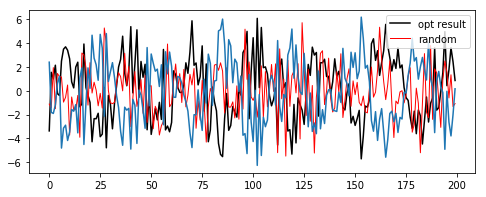

(-3.518469493047732, -0.10459594856764909, -3.3087340427065968)

In [217]:
v_random = np.random.normal(0, 1, (N,))
v_random /= np.sqrt(np.sum(v_random**2))
v_opt /= np.sqrt(np.sum(v_opt**2))

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(np.dot(X, v_opt)[:200], label="opt result", c="black")
ax.plot(np.dot(X, v_random)[:200], label="random", c="red", linewidth=1)
ax.legend()

cov = np.dot(X.T, X)
w, v = scipy.linalg.eigh(cov)
w, v = w[::-1], v[:, ::-1]
PCs = np.dot(X, v)
ax.plot(PCs[:200, 0])

plt.show()

loss(v_opt), loss(v_random), loss(v[:, 0])
